In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from tensorflow.keras.layers import LSTM, Input, Dense, TimeDistributed, RepeatVector, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import seaborn as sns

### Data Generation and preprocessing

In [2]:
# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# create mapping of characters to integers (0-25) and the reverse
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

# one-hot encoding for alphabets
AlphTab = pd.DataFrame(char_to_int,index = [0]).T
AlphOneHot =  pd.get_dummies(AlphTab[0])

AlphOneHot_T =  np.transpose(AlphOneHot.values, (1,0))
FrameDAta = tf.signal.frame(AlphOneHot_T, 6, 1)
FrameDAta = np.transpose(FrameDAta, (1,2,0))

### Data selection for input and output 
InpData = FrameDAta[:,:3, :] # Three input alphabets
TargetData = FrameDAta[:,3:, :] # Three output alphabets

In [3]:
InpData.shape, TargetData.shape

((21, 3, 26), (21, 3, 26))

<AxesSubplot:>

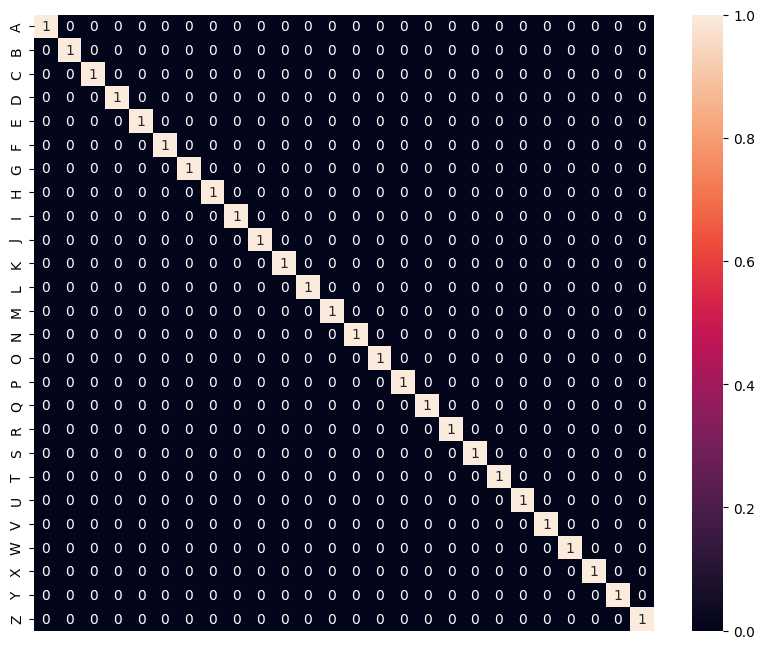

In [21]:
plt.figure(figsize=(10,8))    
sns.heatmap(AlphOneHot.values, yticklabels=[i for i in char_to_int], xticklabels=False, annot=AlphOneHot.values,linewidths=0)

### Model save directory setting

In [4]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

### Model definition

In [5]:
def AlphaModel ():
    InpL = Input(shape=(InpData.shape[1], InpData.shape[2]))
    LSTML = LSTM(20, return_sequences=True)(InpL)
    LSTMOut = LSTM(20, return_sequences=False)(LSTML)

    LSTMOut = RepeatVector(TargetData.shape[1])(LSTMOut)
    Output = TimeDistributed(Dense(20))(LSTMOut)
    Output = LSTM(20, return_sequences=True)(Output)
    Output = Dense(InpData.shape[2], activation='softmax')(Output)
    return Model(InpL,Output)   
    

In [6]:
### Model checkpoint
ModelSaveSameName = save_path+'Alpha.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='loss', verbose=1, save_best_only=True)

### Model Early stop
EarlyStop = EarlyStopping(monitor='loss', patience=100)

AlphaM = AlphaModel()
AlphaM.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam', metrics =['accuracy'])
AlphaMHist = AlphaM.fit(InpData, TargetData, epochs=500, batch_size=5,  verbose=1, callbacks=[ModelSave, EarlyStop])

Epoch 1/500
5/5 [==============================] - 3s 7ms/step - loss: 3.2579 - accuracy: 0.0291 

Epoch 00001: loss improved from inf to 3.25788, saving model to ./Results\Alpha.hdf5
Epoch 2/500
5/5 [==============================] - 0s 7ms/step - loss: 3.2548 - accuracy: 0.0687

Epoch 00002: loss improved from 3.25788 to 3.25467, saving model to ./Results\Alpha.hdf5
Epoch 3/500
5/5 [==============================] - 0s 7ms/step - loss: 3.2525 - accuracy: 0.0575

Epoch 00003: loss improved from 3.25467 to 3.25233, saving model to ./Results\Alpha.hdf5
Epoch 4/500
5/5 [==============================] - 0s 7ms/step - loss: 3.2513 - accuracy: 0.0254

Epoch 00004: loss improved from 3.25233 to 3.24975, saving model to ./Results\Alpha.hdf5
Epoch 5/500
5/5 [==============================] - 0s 7ms/step - loss: 3.2474 - accuracy: 0.0774

Epoch 00005: loss improved from 3.24975 to 3.24688, saving model to ./Results\Alpha.hdf5
Epoch 6/500
5/5 [==============================] - 0s 7ms/step - los

### Model weight load and evaluate it

In [7]:
AlphaM = AlphaModel()
AlphaM.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam', metrics =['accuracy'])
print('Before loading weights')
print(AlphaM.evaluate(InpData,TargetData, batch_size=300 ))
print()

AlphaM.load_weights(ModelSaveSameName)
print('After loading weights')
print(AlphaM.evaluate(InpData,TargetData, batch_size=300))

Before loading weights
1/1 [==============================] - 1s 889ms/step - loss: 3.2576 - accuracy: 0.0635
[3.257601499557495, 0.0634920671582222]

After loading weights
1/1 [==============================] - 0s 15ms/step - loss: 0.3319 - accuracy: 0.9841
[0.3318551778793335, 0.9841269850730896]


### Plot loss graphs

Text(0, 0.5, 'loss')

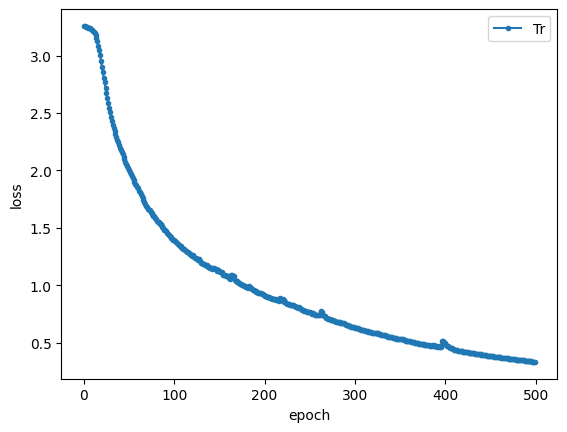

In [8]:
plt.plot(AlphaMHist.history['loss'], label='Tr', marker='.')
plt.legend() 
plt.xlabel('epoch')
plt.ylabel('loss')

### Prediction example

 cde


<AxesSubplot:>

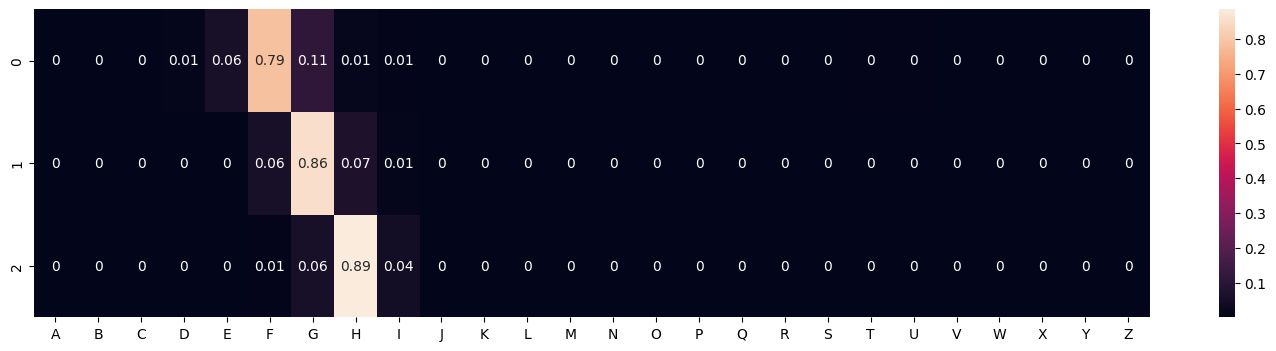

In [22]:
AlphaInp = input().upper()
AlphaInpEncod = [AlphOneHot_T[char_to_int[i]][None] for i in AlphaInp ]
AlphaInpEncod = np.concatenate(AlphaInpEncod, axis=0)
AlphaInpEncod = AlphaInpEncod[None]
AlphaPred = AlphaM.predict(AlphaInpEncod)

plt.figure(figsize=(18,4))    
sns.heatmap(AlphaPred[0], xticklabels=[i for i in char_to_int], annot=np.round(AlphaPred[0], 2),linewidths=0)